In [ ]:
# Load libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, f1_score
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.utils import class_weight
import os

In [ ]:
# Set up Keras ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [ ]:
# Define focal loss for CNN model
def focal_loss(gamma=2.0, alpha=0.25):
  
    def loss_fn(y_true, y_pred):
        # ensure float32
        y_true = tf.cast(y_true, tf.float32)
        # clip preds to prevent log(0) error
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        # p_t is y_pred if label=1, else (1-y_pred)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # weighting factor α for class 1, (1-α) for class 0
        alpha_factor = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
        # focal modulation
        modulating_factor = K.pow(1.0 - p_t, gamma)
        # compute loss
        loss = -alpha_factor * modulating_factor * K.log(p_t)
        return K.mean(loss)
    return loss_fn


In [ ]:
# Build CNN from scratch
def build_cnn(input_shape=(64,64,1), weight_decay=1e-4):
    inp = Input(shape=input_shape)
    x = inp

    # Three convolutional blocks
    for filters in (32, 64, 128):
        x = Conv2D(filters, 3, padding="same",
                   kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Conv2D(filters, 3, padding="same",
                   kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(2)(x)
        x = Dropout(0.3)(x)

    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu",
              kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2., alpha=0.25),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

cbs = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


In [5]:
X = np.load("../data/processed/X.npy")   # shape (N,64,64,1)
y = np.load("../data/processed/y.npy")   # shape (N,)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_histories = []
fold_accs, fold_aucs = [], []


In [12]:
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# --- Part A: Cross‐val aggregation ---
all_test_probs, all_test_labels, all_test_preds = [], [], []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for tv_idx, test_idx in skf.split(X, y):
    # split train+val vs. test
    X_tv, y_tv     = X[tv_idx], y[tv_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # further split tv→train/val (same as you do)
    X_train, X_val, y_train, y_val = train_test_split(
        X_tv, y_tv, test_size=0.2, stratify=y_tv, random_state=42
    )

    # compute class weights on the training portion
    cw = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = {i: w for i, w in enumerate(cw)}

    # build and train
    model = build_cnn()
    model.fit(
        ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode="nearest"
        ).flow(X_train, y_train, batch_size=32),
        validation_data=(X_val, y_val),
        epochs=20,
        class_weight=class_weights,
        callbacks=cbs,
        verbose=0
    )

    # predict on this fold’s test set
    probs = model.predict(X_test).ravel()
    preds = (probs > 0.5).astype(int)

    all_test_probs .append(probs)
    all_test_labels.append(y_test)
    all_test_preds .append(preds)

# concatenate across folds
cv_probs  = np.concatenate(all_test_probs)
cv_labels = np.concatenate(all_test_labels)
cv_preds  = np.concatenate(all_test_preds)

# save CV outputs
np.save(f"{results_dir}/cnn_cv_probs.npy",  cv_probs)
np.save(f"{results_dir}/cnn_cv_labels.npy", cv_labels)
np.save(f"{results_dir}/cnn_cv_preds.npy",  cv_preds)

# --- Part B: Hold‐out split to match baseline model ---
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# train final CNN on 80%
model = build_cnn()
history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    batch_size=32,
    epochs=20,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=0
)

# predict on hold‐out
hold_probs = model.predict(X_hold).ravel()
hold_preds = (hold_probs > 0.5).astype(int)

# save hold‐out outputs
np.save(f"{results_dir}/y_test.npy",      y_hold)
np.save(f"{results_dir}/cnn_probs.npy",   hold_probs)
np.save(f"{results_dir}/cnn_preds.npy",   hold_preds)

/home/emmanuel-ezeobidi/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


/home/emmanuel-ezeobidi/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step


/home/emmanuel-ezeobidi/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


/home/emmanuel-ezeobidi/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


/home/emmanuel-ezeobidi/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [16]:
!ls ../results

cnn_cv_accs.npy   knn_probs.npy   nb_preds.npy	       rf_cv_aucs.npy
cnn_cv_aucs.npy   lr_cv_accs.npy  nb_probs.npy	       rf_preds.npy
cnn_cv_preds.npy  lr_cv_aucs.npy  rbf_svm_cv_accs.npy  rf_probs.npy
cnn_cv_probs.npy  lr_preds.npy	  rbf_svm_cv_aucs.npy  y_test.npy
knn_cv_accs.npy   lr_probs.npy	  rbf_svm_preds.npy
knn_cv_aucs.npy   nb_cv_accs.npy  rbf_svm_probs.npy
knn_preds.npy	  nb_cv_aucs.npy  rf_cv_accs.npy


In [23]:
!ls ../results

cnn_cv_accs.npy   knn_probs.npy   nb_preds.npy	       rf_cv_aucs.npy
cnn_cv_aucs.npy   lr_cv_accs.npy  nb_probs.npy	       rf_preds.npy
cnn_cv_preds.npy  lr_cv_aucs.npy  rbf_svm_cv_accs.npy  rf_probs.npy
cnn_cv_probs.npy  lr_preds.npy	  rbf_svm_cv_aucs.npy  y_test.npy
knn_cv_accs.npy   lr_probs.npy	  rbf_svm_preds.npy
knn_cv_aucs.npy   nb_cv_accs.npy  rbf_svm_probs.npy
knn_preds.npy	  nb_cv_aucs.npy  rf_cv_accs.npy


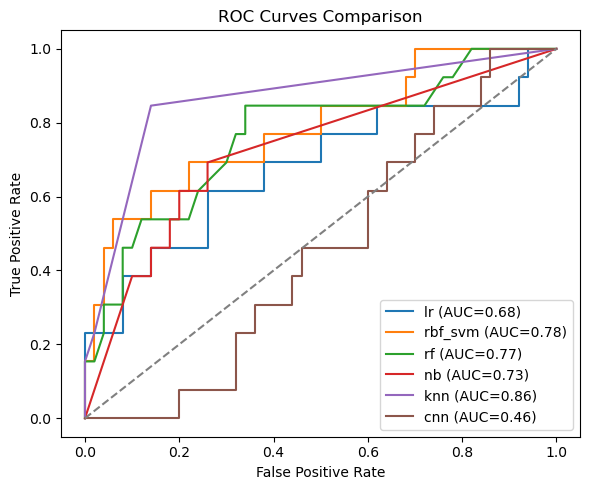

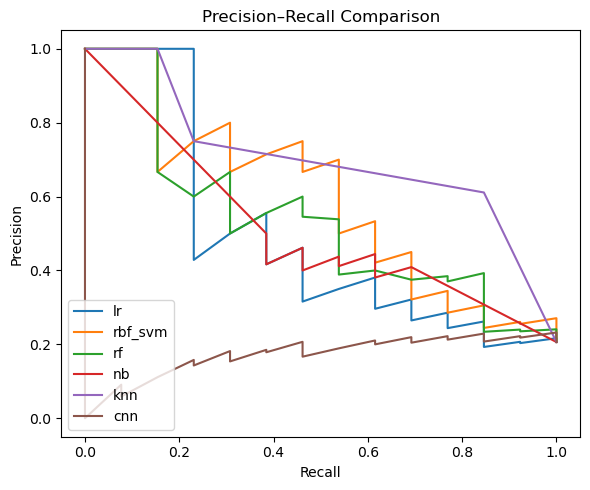

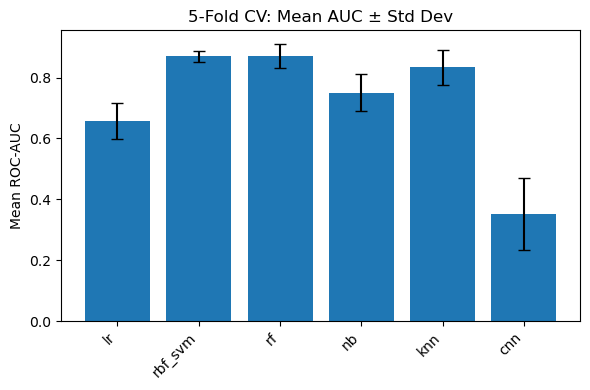

/tmp/ipykernel_3501/6880292.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_acc, labels=names)


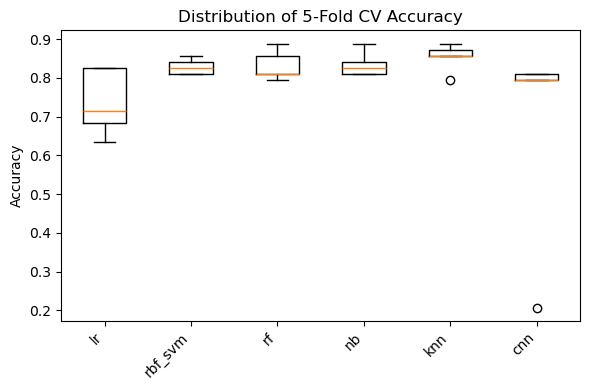

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1) Load hold-out labels and per-model test probs
y_test = np.load("../results/y_test.npy")
models = ["Logistic", "SVM", "kNN", "RF", "NB", "CNN"]

y_prob_dict = {
    'lr':       np.load('../results/lr_probs.npy'),
    'rbf_svm':      np.load('../results/rbf_svm_probs.npy'),
    'rf':       np.load('../results/rf_probs.npy'),
    'nb':       np.load('../results/nb_probs.npy'),
    'knn':       np.load('../results/knn_probs.npy'),
    'cnn':      np.load('../results/cnn_probs.npy', allow_pickle=True)
}

# 2) Load CV‐fold metrics
auc_scores = {m: np.load(f"../results/{m}_cv_aucs.npy", allow_pickle=True) for m in y_prob_dict}
acc_scores = {m: np.load(f"../results/{m}_cv_accs.npy", allow_pickle=True) for m in y_prob_dict}

# --- Figure 1: ROC Curves ---
plt.figure(figsize=(6,5))
for name, probs in y_prob_dict.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Figure 2: Precision–Recall Curves ---
plt.figure(figsize=(6,5))
for name, probs in y_prob_dict.items():
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(rec, prec, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Comparison")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# --- Figure 3: Bar Chart of Mean CV AUC ± Std ---
names = list(auc_scores.keys())
means = [auc_scores[n].mean() for n in names]
stds  = [auc_scores[n].std()  for n in names]
x = np.arange(len(names))

plt.figure(figsize=(6,4))
plt.bar(x, means, yerr=stds, capsize=4)
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("Mean ROC‐AUC")
plt.title("5‐Fold CV: Mean AUC ± Std Dev")
plt.tight_layout()
plt.show()

# --- Figure 4: Box‐Plot of CV Accuracy ---
data_acc = [acc_scores[n] for n in names]
plt.figure(figsize=(6,4))
plt.boxplot(data_acc, labels=names)
plt.ylabel("Accuracy")
plt.title("Distribution of 5‐Fold CV Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [18]:
import numpy as np
import pandas as pd

# List of model identifiers and their display names
models = {
    'lr': 'Logistic Regression',
    'rbf_svm': 'RBF SVM',
    'knn': 'k‑Nearest Neighbors (k=5)',
    'rf': 'Random Forest',
    'nb': 'Gaussian Naïve Bayes',
    'cnn': 'Focal‑Loss CNN'
}

# Collect results
results = []
for key, display_name in models.items():
    accs = np.load(f"../results/{key}_cv_accs.npy")
    aucs = np.load(f"../results/{key}_cv_aucs.npy")
    results.append({
        'Model': display_name,
        'Accuracy Mean': np.mean(accs),
        'Accuracy Std': np.std(accs),
        'AUC Mean': np.mean(aucs),
        'AUC Std': np.std(aucs)
    })

# Create a DataFrame and display
df = pd.DataFrame(results)
print(df)


                       Model  Accuracy Mean  Accuracy Std  AUC Mean   AUC Std
0        Logistic Regression       0.736508      0.076849  0.657646  0.058673
1                    RBF SVM       0.828571      0.018511  0.869368  0.017605
2  k‑Nearest Neighbors (k=5)       0.853968      0.032375  0.833590  0.057990
3              Random Forest       0.831746      0.035635  0.870368  0.039159
4       Gaussian Naïve Bayes       0.834921      0.029440  0.749944  0.061254
5             Focal‑Loss CNN       0.682540      0.238201  0.352705  0.118770
